In [1]:
# are the future functions actually necessary?
from __future__ import absolute_import, division, print_function, unicode_literals
import imp

from data_read import read_RPE_and_TPS
from pathData import PathData
from snapData import SnapData
from datasetData import DatasetData
from plotData import PlotData
from importanceData import ImportanceData
from globalConstants import Const
from autoEncoder import AutoEncoder 
from stepwiseData import StepwiseData
from gridData import GridData
from reduce import Reducer
#from data_plot import map_generated

import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

import random
import time
from collections import Counter

np.set_printoptions(precision=3, suppress=True)
# allows for automatic reloading of imports and makes it unncessecary to restart the kernel
# whenever a function is changed
%load_ext autoreload
%autoreload 2

In [2]:
c = Const()
#c.RPE_folder_name = "RPE_org"

#used_vars = [0, 1, 7, 8, 9, 10, 11, 13, 3]
#used_vars = [0, 2, 5, 6, 7, 8, 9, 11, 13, 17, 18, 19, 20, 21]
#used_vars = [
#    0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 
#    12, 13, 14, 15, 16, 17, 18, 19, 20, 21
#    ]

In [3]:
# frame, mcg, now4, now3, now2, sw34, sw23, f4_value, 
# rg2_value, cage_big, cage_small, cage_ratio, 
# surface_carbon_2, surface_carbon_3, n_core_2, 
# n_core_3, surface_carbon_4, n_core_4

"5^{12}6^{3}, 5^{12}6^{4}, 4^{1}5^{10}6^{2}, 4^{1}5^{10}6^{3}, 4^{1}5^{10}6^{4}"


'5^{12}6^{3}, 5^{12}6^{4}, 4^{1}5^{10}6^{2}, 4^{1}5^{10}6^{3}, 4^{1}5^{10}6^{4}'

In [4]:
pathO = PathData(
    *read_RPE_and_TPS(
        c.RPE_folder_name, 
        c.TPS_folder_name, 
        c.mcg_A, 
        c.mcg_B,
        c.big_C,
        c.used_frac,
        c.used_frac), 
    c.path_type_labels, 
    c.path_type_weights)

Read RPE files
mcg100
Total paths: 552	 Used paths: 55
mcg70
Total paths: 699	 Used paths: 69
mcg30
Total paths: 2776	 Used paths: 277
mcg80
Total paths: 539	 Used paths: 53
mcg35
Total paths: 1288	 Used paths: 128
mcg90
Total paths: 292	 Used paths: 29
mcg50
Total paths: 2838	 Used paths: 283
mcg60
Total paths: 1090	 Used paths: 109
mcg40
Total paths: 1652	 Used paths: 165
mcg45
Total paths: 2130	 Used paths: 213
Sum weights: 0.0535066719946907
Mean weights: 3.8744874724613076e-05
Read TPS files
Path in 368.txt begins (mcg = 2.0) or ends (mcg = 52.0) outside of state definition.
Path in 332.txt begins (mcg = 2.0) or ends (mcg = 60.0) outside of state definition.
Path in 372.txt begins (mcg = 2.0) or ends (mcg = 52.0) outside of state definition.
Path in 333.txt begins (mcg = 2.0) or ends (mcg = 60.0) outside of state definition.
Total paths: 90	 Used paths: 9
1.6982388117803513e-13


In [5]:
#from data_read import read_TPS
#from data_read import read_RPE
#RPE_paths, RPE_labels, RPE_weights, RPE_names = read_RPE(c.RPE_folder_name, 
#    c.mcg_A, c.mcg_B, c.big_C, 0.1) 
#TPS_paths, TPS_labels, TPS_weights, TPS_names = read_TPS(c.TPS_folder_name, 
#    c.mcg_A, c.mcg_B, c.big_C, 0.7, 1) 

In [6]:
snapO = SnapData(
    *pathO.snapshots_labels_weights(
        offset = c.offset, 
        progress = c.progress, 
        transitioned = c.transitioned, 
        turnedback = c.turnedback))


Mean weights: 0.27751735151951396
Sum weights AA: 190849.5151783007	 Sum weights AB: 1.4785065366080922e-05
Sum weights AA after: 190849.5151783007	 Sum weights AB after: 1.4785065366080922e-05


In [7]:
dataO = DatasetData(
    *snapO.split_lists(c.train_ratio, c.val_ratio), 
    outlier_cutoff = c.outlier_cutoff, 
    resolution = c.resolution)


In [8]:
gridO = GridData(c.resolution)


In [ ]:
reduced_list_var_names = ["MCG", "5^{12}6^{2}", "5^{12}",
          "CR", "R_g", "F4"]
reduced_list_var_names = ['MCG', 'N_{s,2}', 'N_{s,3}', 'N_{s,4}', 'N_{c,2}', "5^{12}6^{2}", "5^{12}"]
reduced_name_to_list_position = {reduced_list_var_names[i]: i for i in range(len(reduced_list_var_names))}

reducer6 = Reducer(reduced_list_var_names, c.name_to_list_position)

In [ ]:

train_grid_past_snapshots = dataO.train_grid_past_snapshots
train_reduced_grid_past_snapshots = reducer6.reduce_snapshots(train_grid_past_snapshots)
#train_grid_snapshots = train_grid_past_snapshots
val_grid_past_snapshots = dataO.val_grid_past_snapshots
val_reduced_grid_past_snapshots = reducer6.reduce_snapshots(val_grid_past_snapshots)
#val_grid_snapshots = val_grid_past_snapshots


In [27]:
train_pB_dict, train_pBs = gridO.approximate_pB(
    train_reduced_grid_past_snapshots,
    dataO.train_snapshot_labels,
    dataO.train_snapshot_weights)
train_pBs_len = len(train_pBs)

val_pB_dict, val_pBs = gridO.approximate_pB(
    val_reduced_grid_past_snapshots,
    dataO.val_snapshot_labels, 
    dataO.val_snapshot_weights)
val_pBs_len = len(val_pBs)

Fill hash maps
Rescale
Fill hash maps
Rescale


In [28]:
train_trimmed_pB_dict = {key: label for key, label in train_pB_dict.items() if label > 0 and label < 1}
print(len(train_trimmed_pB_dict))

4173


In [29]:

bins = 10

# contains numbers higher than bins but those are the points where pB = 1, 
# which should therefore not be considered
train_round_pBs = np.ceil((np.array(train_pBs) * (bins + 1)))
val_round_pBs = np.ceil((np.array(val_pBs) * (bins + 1)))

train_counter = Counter(train_round_pBs)
val_counter = Counter(val_round_pBs)
train_normed_counter = {key: train_pBs_len/label for key, label in train_counter.items()}
val_normed_counter = {key: val_pBs_len/label for key, label in val_counter.items()}
train_normed_and_trimmed_counter = {key: train_pBs_len/label if key > 0 and key <= bins else 0 \
    for key, label in train_counter.items()}
val_normed_and_trimmed_counter = {key: val_pBs_len/label if key > 0 and key <= bins else 0 \
    for key, label in val_counter.items()}

print(train_normed_counter)
print(val_normed_counter)
print(train_normed_and_trimmed_counter)
print(val_normed_and_trimmed_counter)

#train_pB_normed_weights = np.array([normed_counter[i] for i in train_round_pBs])
train_pB_normed_weights = np.array([train_normed_counter[i] for i in train_round_pBs])
val_pB_normed_weights = np.array([val_normed_counter[i] for i in val_round_pBs])
train_pB_normed_and_trimmed_weights = np.array([train_normed_and_trimmed_counter[i] for i in train_round_pBs])
val_pB_normed_and_trimmed_weights = np.array([val_normed_and_trimmed_counter[i] for i in val_round_pBs])
#print(train_pB_normed_weights[:20])
#print(train_round_pBs[:20])
#print(train_pBs[:20])
#print((np.array(train_pBs)[:20] * (bins+1)))

pass

{1.0: 1.4556586467226416, 0.0: 3.6527416299286486, 11.0: 69.97134136001357, 6.0: 399.4394966118103, 3.0: 202.56308296514482, 10.0: 1974.2631578947369, 8.0: 740.7917414721724, 2.0: 138.04650384744062, 5.0: 476.4676674364896, 9.0: 693.4806722689076, 4.0: 276.18540829986614, 7.0: 790.4616858237548}
{1.0: 3.104039720153464, 0.0: 1.5590922487474212, 5.0: 1091.5873015873017, 2.0: 226.2171052631579, 6.0: 386.34831460674155, 4.0: 440.8333333333333, 11.0: 50.60338484179544, 9.0: 2750.8, 3.0: 241.2982456140351, 8.0: 731.5957446808511, 7.0: 2292.3333333333335, 10.0: 5730.833333333333}
{1.0: 1.4556586467226416, 0.0: 0, 11.0: 0, 6.0: 399.4394966118103, 3.0: 202.56308296514482, 10.0: 1974.2631578947369, 8.0: 740.7917414721724, 2.0: 138.04650384744062, 5.0: 476.4676674364896, 9.0: 693.4806722689076, 4.0: 276.18540829986614, 7.0: 790.4616858237548}
{1.0: 3.104039720153464, 0.0: 0, 5.0: 1091.5873015873017, 2.0: 226.2171052631579, 6.0: 386.34831460674155, 4.0: 440.8333333333333, 11.0: 0, 9.0: 2750.8, 3.

In [30]:

train_full_pB_normed_weights = dataO.train_snapshot_weights * train_pB_normed_weights
val_full_pB_normed_weights = dataO.val_snapshot_weights * val_pB_normed_weights

train_full_pB_normed_and_trimmed__weights = dataO.train_snapshot_weights * train_pB_normed_and_trimmed_weights
val_full_pB_normed_and_trimmed_weights = dataO.val_snapshot_weights * val_pB_normed_and_trimmed_weights
pass

In [31]:
"""plt.figure()
plt.hist(train_pBs, 100)
plt.show()
plt.figure()
plt.hist(train_round_pBs, 100)
plt.show()"""

'plt.figure()\nplt.hist(train_pBs, 100)\nplt.show()\nplt.figure()\nplt.hist(train_round_pBs, 100)\nplt.show()'

In [32]:

train_reduced_normed_snapshots = \
    reducer6.reduce_snapshots(dataO.train_norm_past_snapshots)
val_reduced_normed_snapshots = \
    reducer6.reduce_snapshots(dataO.val_norm_past_snapshots)


In [33]:
train_pBn_ds = tf.data.Dataset.from_tensor_slices(
    ({c.input_name: train_reduced_normed_snapshots}, 
    {c.output_name_1: dataO.train_snapshot_labels, 
    c.output_name_2: train_reduced_normed_snapshots},
    {c.output_name_1: train_pB_normed_weights, 
    c.output_name_2: train_pB_normed_weights})) \
        .shuffle(snapO.snapshot_cnt) \
        .batch(c.batch_size)
val_pBn_ds = tf.data.Dataset.from_tensor_slices(
    ({c.input_name: val_reduced_normed_snapshots}, 
    {c.output_name_1: dataO.val_snapshot_labels, 
    c.output_name_2: val_reduced_normed_snapshots}, 
    {c.output_name_1: val_pB_normed_weights, 
    c.output_name_2: val_pB_normed_weights})) \
        .shuffle(snapO.snapshot_cnt) \
        .batch(c.batch_size)


In [34]:
train_pBnat_ds = tf.data.Dataset.from_tensor_slices(
    ({c.input_name: train_reduced_normed_snapshots}, 
    {c.output_name_1: dataO.train_snapshot_labels, 
    c.output_name_2: train_reduced_normed_snapshots},
    {c.output_name_1: train_pB_normed_and_trimmed_weights, 
    c.output_name_2: train_pB_normed_and_trimmed_weights})) \
        .shuffle(snapO.snapshot_cnt) \
        .batch(c.batch_size)
val_pBnat_ds = tf.data.Dataset.from_tensor_slices(
    ({c.input_name: val_reduced_normed_snapshots}, 
    {c.output_name_1: dataO.val_snapshot_labels, 
    c.output_name_2: val_reduced_normed_snapshots}, 
    {c.output_name_1: val_pB_normed_and_trimmed_weights, 
    c.output_name_2: val_pB_normed_and_trimmed_weights})) \
        .shuffle(snapO.snapshot_cnt) \
        .batch(c.batch_size)

In [35]:
#nonZeroOne_gridpoints = [key for key, label in train_pB_dict.items() if label > 0  and label < 1]


In [36]:
modelO = AutoEncoder(c)
(autoencoder, autoencoder_1, autoencoder_2) = \
    modelO.model(len(reduced_list_var_names))
history = autoencoder.fit(
    train_pBnat_ds,epochs = 1,  
    validation_data = val_pBnat_ds)


Train for 6448 steps, validate for 1075 steps
6448/6448 [==============================] - 25s 4ms/step - loss: 18.3393 - label_loss: 6.5414 - reconstruction_loss: 11.7980 - val_loss: 16.1810 - val_label_loss: 6.6234 - val_reconstruction_loss: 9.5575


1: N_{s,2}	0: MCG
2: N_{s,3}	0: MCG
2: N_{s,3}	1: N_{s,2}
3: N_{s,4}	0: MCG
3: N_{s,4}	1: N_{s,2}
3: N_{s,4}	2: N_{s,3}
4: N_{c,2}	0: MCG
4: N_{c,2}	1: N_{s,2}
4: N_{c,2}	2: N_{s,3}
4: N_{c,2}	3: N_{s,4}
5: N_{c,3}	0: MCG
5: N_{c,3}	1: N_{s,2}
5: N_{c,3}	2: N_{s,3}
5: N_{c,3}	3: N_{s,4}
5: N_{c,3}	4: N_{c,2}
6: N_{c,4}	0: MCG
6: N_{c,4}	1: N_{s,2}
6: N_{c,4}	2: N_{s,3}
6: N_{c,4}	3: N_{s,4}
6: N_{c,4}	4: N_{c,2}
6: N_{c,4}	5: N_{c,3}
0


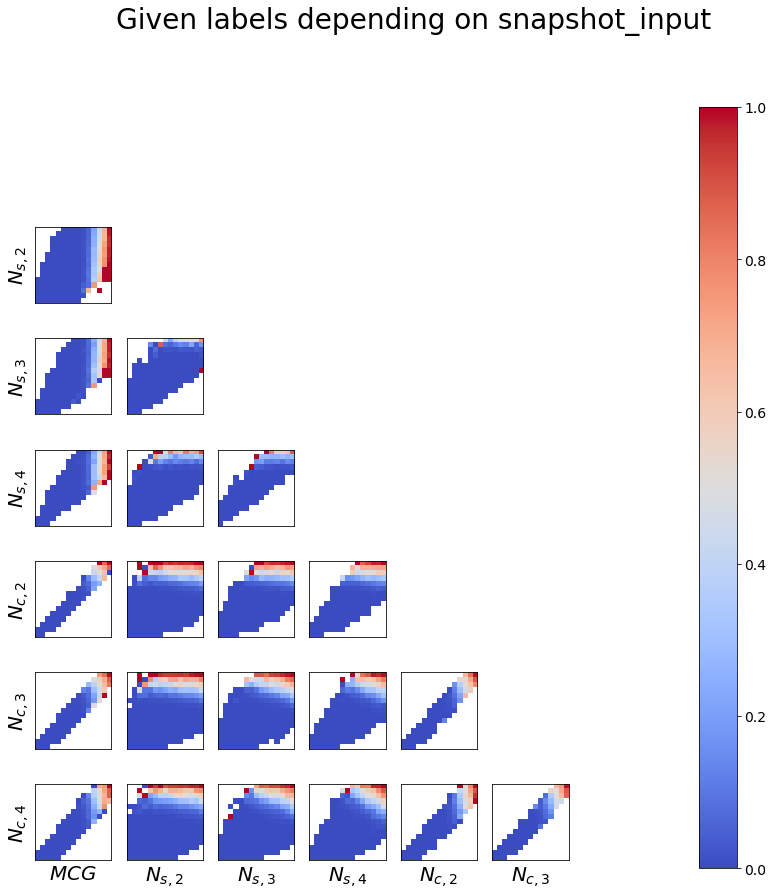

In [37]:
plotO = PlotData(train_reduced_grid_past_snapshots, 
    dataO.minima,
    dataO.maxima,
    dataO.train_snapshot_labels,
    dataO.train_snapshot_weights,
    "testing_"+c.stamp)
super_map = plotO.plot_super_map(
        subfig_size = c.subfig_size, 
        used_variable_names = reduced_list_var_names,
    #    used_variable_names = c.names_in_order, 
        name_to_list_position = reduced_name_to_list_position, 
        resolution = c.resolution,
        vmin = c.min_label, vmax = c.max_label, model = None, fill_val = 0)
pass

In [38]:
def plot_with_different_settings(train_ds, val_ds, bonus_stamp):
    modelO = AutoEncoder(c)
    #(autoencoder, autoencoder_1, autoencoder_2) = \
    #    modelO.model(dataO.dimensions)
    (autoencoder, autoencoder_1, autoencoder_2) = \
        modelO.model(len(reduced_list_var_names))
    #autoencoder.fit(train_ds_batch,epochs=EPOCHS, class_weight=class_weight)
    history = autoencoder.fit(
        train_ds,epochs = 5,  
        validation_data = val_ds)
    #history = autoencoder.fit(
    #    train_ds,epochs = c.epochs,  
    #    validation_data = val_ds)
    plotO = PlotData(dataO.train_grid_past_snapshots, 
        dataO.minima,
        dataO.maxima,
        dataO.train_snapshot_labels,
        dataO.train_snapshot_weights,
        bonus_stamp+c.stamp)
    plotO.plot_super_map(
        subfig_size = c.subfig_size, 
        used_variable_names = reduced_list_var_names,
        #used_variable_names = c.names_in_order,  
        name_to_list_position = reduced_name_to_list_position, 
        resolution = c.resolution,
        vmin = c.min_label, vmax = c.max_label, 
        model = autoencoder_1, fill_val = 0)
    plotO.plot_super_map(
        subfig_size = c.subfig_size, 
        used_variable_names = reduced_list_var_names,
        #used_variable_names = c.names_in_order,  
        name_to_list_position = reduced_name_to_list_position, 
        resolution = c.resolution,
        vmin = c.min_label, vmax = c.max_label, 
        model = autoencoder_1, fill_val = 0,
        points_of_interest = train_trimmed_pB_dict)
    plotO.plot_super_scatter(
        subfig_size = c.subfig_size, 
        used_variable_names = reduced_list_var_names, 
        name_to_list_position = reduced_name_to_list_position, 
        resolution = c.resolution,
        model = autoencoder_2, max_row_len = 6,
        fill_val = 0)

Train for 6448 steps, validate for 1075 steps
Epoch 1/5
6448/6448 [==============================] - 18s 3ms/step - loss: 18.2778 - label_loss: 6.4886 - reconstruction_loss: 11.7892 - val_loss: 16.1143 - val_label_loss: 6.5366 - val_reconstruction_loss: 9.5777
Epoch 2/5
6448/6448 [==============================] - 17s 3ms/step - loss: 17.9542 - label_loss: 6.2031 - reconstruction_loss: 11.7512 - val_loss: 16.0803 - val_label_loss: 6.4928 - val_reconstruction_loss: 9.5875
Epoch 3/5
6448/6448 [==============================] - 17s 3ms/step - loss: 17.8946 - label_loss: 6.1588 - reconstruction_loss: 11.7359 - val_loss: 16.3101 - val_label_loss: 6.7514 - val_reconstruction_loss: 9.5587
Epoch 4/5
6448/6448 [==============================] - 17s 3ms/step - loss: 17.8992 - label_loss: 6.1594 - reconstruction_loss: 11.7399 - val_loss: 16.8678 - val_label_loss: 7.3242 - val_reconstruction_loss: 9.5436
Epoch 5/5
6448/6448 [==============================] - 17s 3ms/step - loss: 17.8465 - label_lo

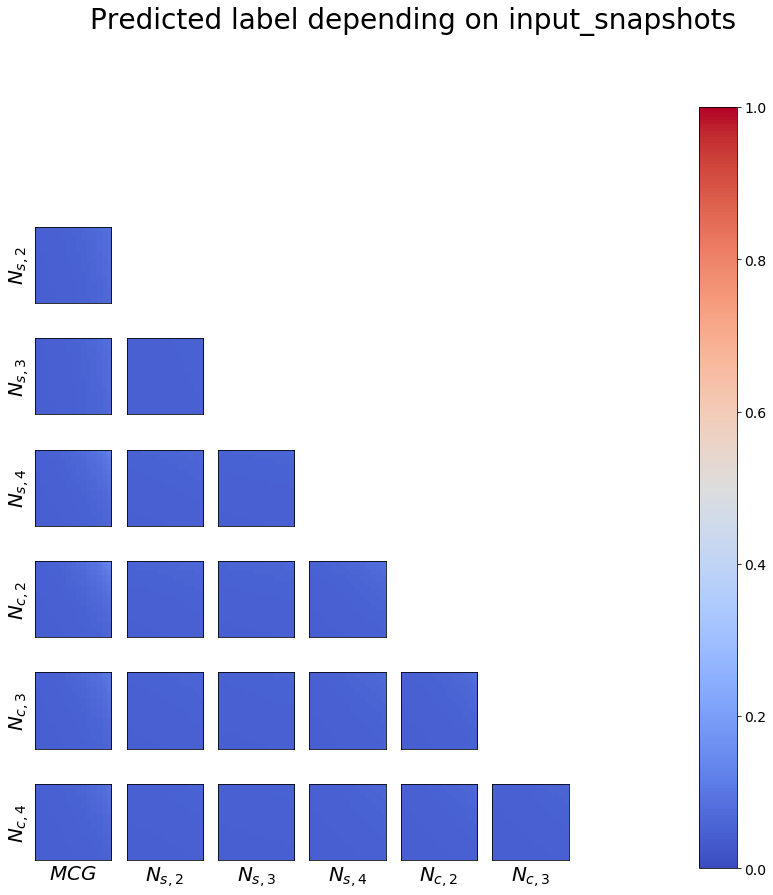

1: N_{s,2}	0: MCG
2: N_{s,3}	0: MCG
2: N_{s,3}	1: N_{s,2}
3: N_{s,4}	0: MCG
3: N_{s,4}	1: N_{s,2}
3: N_{s,4}	2: N_{s,3}
4: N_{c,2}	0: MCG
4: N_{c,2}	1: N_{s,2}
4: N_{c,2}	2: N_{s,3}
4: N_{c,2}	3: N_{s,4}
5: N_{c,3}	0: MCG
5: N_{c,3}	1: N_{s,2}
5: N_{c,3}	2: N_{s,3}
5: N_{c,3}	3: N_{s,4}
5: N_{c,3}	4: N_{c,2}
6: N_{c,4}	0: MCG
6: N_{c,4}	1: N_{s,2}
6: N_{c,4}	2: N_{s,3}
6: N_{c,4}	3: N_{s,4}
6: N_{c,4}	4: N_{c,2}
6: N_{c,4}	5: N_{c,3}
0


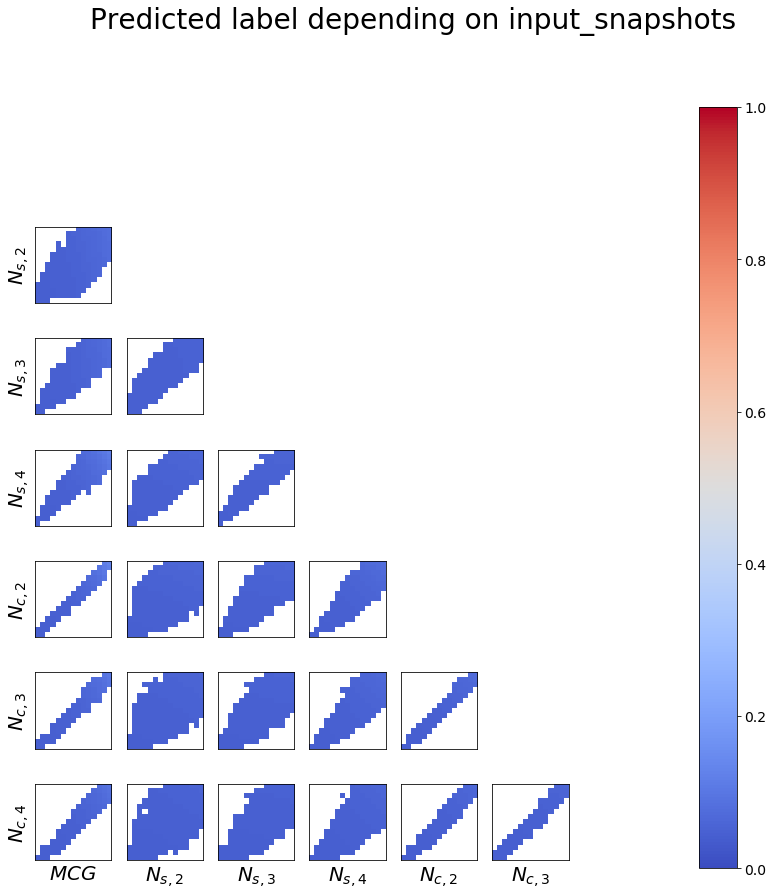

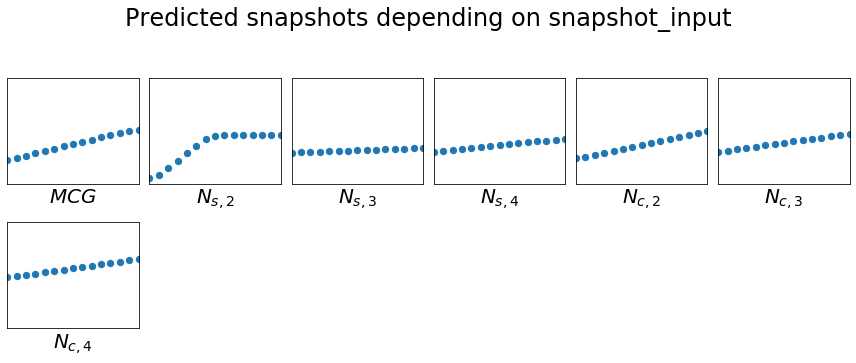

In [39]:
plot_with_different_settings(train_pBnat_ds, val_pBnat_ds, "pB_normed_and_trimmed_as_weights_")

Train for 6448 steps, validate for 1075 steps
Epoch 1/5
6448/6448 [==============================] - 21s 3ms/step - loss: 20.9732 - label_loss: 7.0250 - reconstruction_loss: 13.9482 - val_loss: 19.9098 - val_label_loss: 8.3936 - val_reconstruction_loss: 11.5162
Epoch 2/5
6448/6448 [==============================] - 20s 3ms/step - loss: 20.4251 - label_loss: 6.5422 - reconstruction_loss: 13.8830 - val_loss: 18.7253 - val_label_loss: 7.3084 - val_reconstruction_loss: 11.4170
Epoch 3/5
6448/6448 [==============================] - 18s 3ms/step - loss: 20.3728 - label_loss: 6.5010 - reconstruction_loss: 13.8718 - val_loss: 18.9496 - val_label_loss: 7.5181 - val_reconstruction_loss: 11.4315
Epoch 4/5
6448/6448 [==============================] - 20s 3ms/step - loss: 20.3441 - label_loss: 6.4765 - reconstruction_loss: 13.8676 - val_loss: 19.7095 - val_label_loss: 8.2723 - val_reconstruction_loss: 11.4372
Epoch 5/5
6448/6448 [==============================] - 19s 3ms/step - loss: 20.3312 - labe

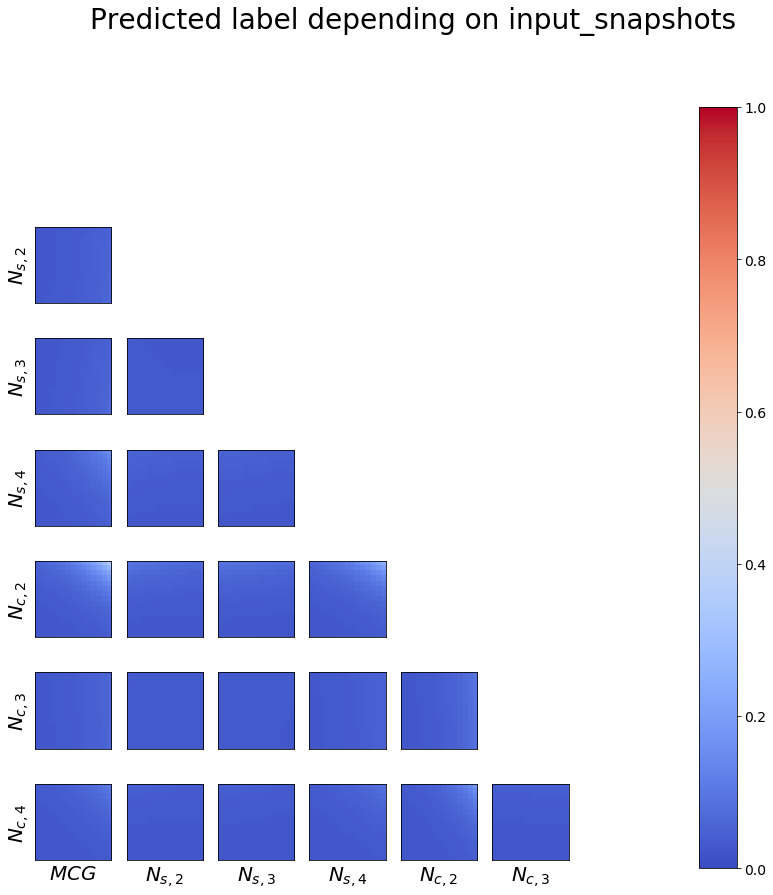

1: N_{s,2}	0: MCG
2: N_{s,3}	0: MCG
2: N_{s,3}	1: N_{s,2}
3: N_{s,4}	0: MCG
3: N_{s,4}	1: N_{s,2}
3: N_{s,4}	2: N_{s,3}
4: N_{c,2}	0: MCG
4: N_{c,2}	1: N_{s,2}
4: N_{c,2}	2: N_{s,3}
4: N_{c,2}	3: N_{s,4}
5: N_{c,3}	0: MCG
5: N_{c,3}	1: N_{s,2}
5: N_{c,3}	2: N_{s,3}
5: N_{c,3}	3: N_{s,4}
5: N_{c,3}	4: N_{c,2}
6: N_{c,4}	0: MCG
6: N_{c,4}	1: N_{s,2}
6: N_{c,4}	2: N_{s,3}
6: N_{c,4}	3: N_{s,4}
6: N_{c,4}	4: N_{c,2}
6: N_{c,4}	5: N_{c,3}
0


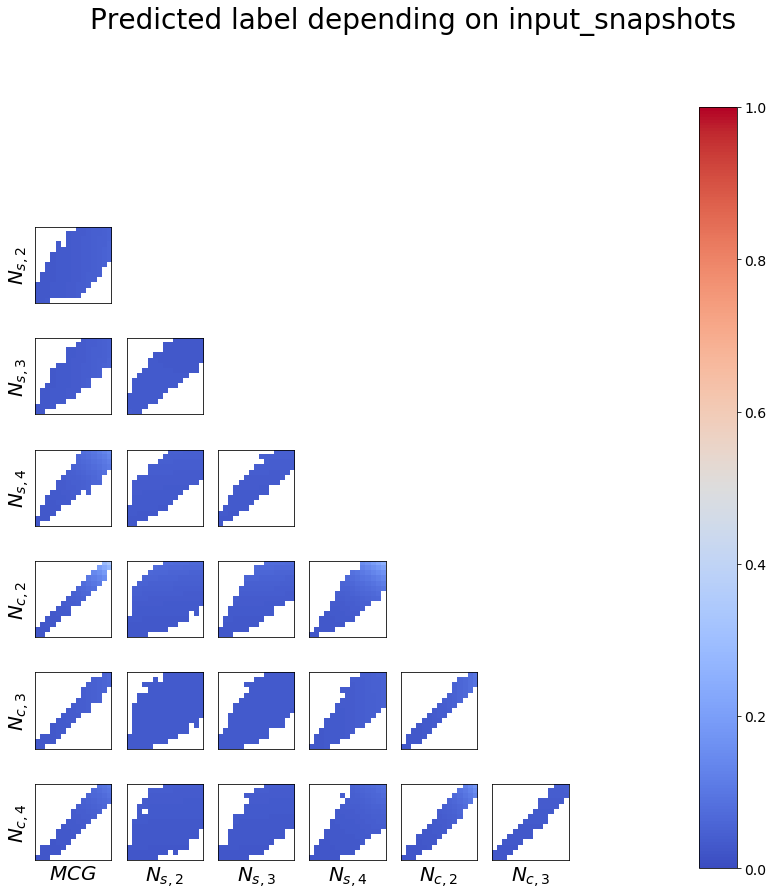

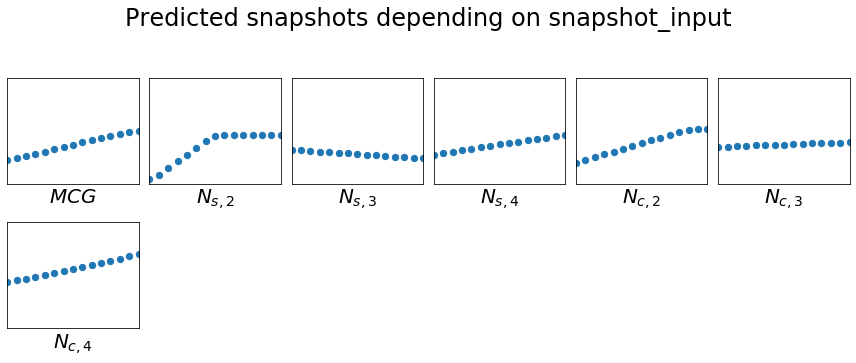

In [40]:
plot_with_different_settings(train_pBn_ds, val_pBn_ds, "pB_normed_as_weights_")

In [41]:
train_ds = tf.data.Dataset.from_tensor_slices(
    ({c.input_name: train_reduced_normed_snapshots}, 
    {c.output_name_1: dataO.train_snapshot_labels, 
    c.output_name_2: train_reduced_normed_snapshots},
    {c.output_name_1: dataO.train_snapshot_weights, 
    c.output_name_2: dataO.train_snapshot_weights})) \
        .shuffle(snapO.snapshot_cnt) \
        .batch(c.batch_size)
val_ds = tf.data.Dataset.from_tensor_slices(
    ({c.input_name: val_reduced_normed_snapshots}, 
    {c.output_name_1: dataO.val_snapshot_labels, 
    c.output_name_2: val_reduced_normed_snapshots}, 
    {c.output_name_1: dataO.val_snapshot_weights, 
    c.output_name_2: dataO.val_snapshot_weights})) \
        .shuffle(snapO.snapshot_cnt) \
        .batch(c.batch_size)  

In [43]:
#plot_with_different_settings(train_ds, val_ds, "standard_weights_")

In [ ]:
train_pB_ds = tf.data.Dataset.from_tensor_slices(
    ({c.input_name: train_reduced_normed_snapshots}, 
    {c.output_name_1: dataO.train_snapshot_labels, 
    c.output_name_2: train_reduced_normed_snapshots},
    {c.output_name_1: train_pBs, 
    c.output_name_2: train_pBs})) \
        .shuffle(snapO.snapshot_cnt) \
        .batch(c.batch_size)
val_pB_ds = tf.data.Dataset.from_tensor_slices(
    ({c.input_name: val_reduced_normed_snapshots}, 
    {c.output_name_1: dataO.val_snapshot_labels, 
    c.output_name_2: val_reduced_normed_snapshots}, 
    {c.output_name_1: val_pBs, 
    c.output_name_2: val_pBs})) \
        .shuffle(snapO.snapshot_cnt) \
        .batch(c.batch_size)  

In [ ]:
#plot_with_different_settings(train_pB_ds, val_pB_ds, "pBs_as_weights_")

In [ ]:
#print(autoencoder_1.predict([[0,0,4,4,0,0,0,0,0,0,0,0,0,0,0,0,0]]))
#print(model.predict([[x if x_var == pos_nr else y if \
#                      y_var == pos_nr else fill_val \
#                      for pos_nr in range(in_size)]])[0])

In [25]:
stepO = StepwiseData(*dataO.stepwise_data())

In [26]:
print(c.names_in_order)

['MCG', 'N_{s,2}', 'N_{s,3}', 'N_{s,4}', 'N_{c,2}', 'N_{c,3}', 'N_{c,4}', 'N_{w,2}', 'N_{w,3}', 'N_{w,4}', 'N_{sw,2-3}', 'N_{sw,3-4}', '5^{12}', '5^{12}6^{2}', 'CR', 'R_g', 'F4']


In [ ]:
used, loss = stepO.bottom_up(
    used = [], 
    #unused = c.names_in_order, 
    unused = reduced_list_var_names,
    name_to_list_position = reduced_name_to_list_position,
    param_limit = 8, 
    epochs = 2, 
    repetitions = 1, 
    const = c)

['MCG']
 Repetition 1
  Mean loss: 7.726432826871132e-10
['N_{w,4}']
 Repetition 1
  Mean loss: 7.737716023470398e-10
['N_{w,3}']
 Repetition 1
  Mean loss: 7.731269513477912e-10
['R_g']
 Repetition 1
  Mean loss: 7.742423369094809e-10
['F4']
 Repetition 1
  Mean loss: 7.736438711880567e-10
['CR']
 Repetition 1
  Mean loss: 7.741089991242234e-10
Added MCG
['MCG', 'N_{w,4}']
 Repetition 1
  Mean loss: 7.99790067507189e-10
['MCG', 'N_{w,3}']
 Repetition 1
  Mean loss: 7.996568962553852e-10
['MCG', 'R_g']
 Repetition 1
  Mean loss: 7.960878067869714e-10
['MCG', 'F4']
 Repetition 1
  Mean loss: 7.945686331112256e-10
['MCG', 'CR']
 Repetition 1


In [38]:
print(used, loss)

['N_{s,2}', 'MCG', 'N_{c,2}', 'N_{s,4}', 'N_{s,3}'] 3.0463082e-10


In [24]:
used, loss = stepO.top_down( 
    #used = c.names_in_order, 
    used = reduced_list_var_names, 
    unused = [], 
    name_to_list_position = reduced_name_to_list_position,
    param_limit = 3, 
    epochs = 2, 
    repetitions = 1, 
    const = c)

NameError: name 'stepO' is not defined

In [41]:
print(used, loss)

['MCG', 'N_{s,4}', 'N_{c,2}'] 2.9373975e-10


In [15]:
impO = ImportanceData(
    *dataO.importance_data(),
    c.corr_thresholds)

impO.measure_correlation()
pass

Caution!
Correlation between input data can affect the reliability of the importance measure.
Strong correlations of more than 0.5 were found between 92 pair(s) of input variables:
	1,0: 0.987
	2,0: 0.999
	2,1: 0.994
	3,0: 1.002
	3,1: 0.987
	3,2: 1.000
	4,0: 0.991
	4,1: 0.963
	4,2: 0.992
	4,3: 0.993
	5,0: 0.984
	5,1: 0.948
	5,2: 0.970
	5,3: 0.987
	5,4: 0.973
	8,0: 0.781
	8,1: 0.809
	8,2: 0.799
	8,3: 0.789
	8,4: 0.772
	8,5: 0.750
	9,0: 0.901
	9,1: 0.894
	9,2: 0.904
	9,3: 0.899
	9,4: 0.897
	9,5: 0.868
	9,8: 0.583
	10,8: 0.701
	11,0: 0.808
	11,1: 0.769
	11,2: 0.788
	11,3: 0.800
	11,4: 0.793
	11,5: 0.809
	11,8: 0.600
	11,9: 0.686
	12,0: 0.909
	12,1: 0.869
	12,2: 0.890
	12,3: 0.902
	12,4: 0.895
	12,5: 0.908
	12,8: 0.670
	12,9: 0.783
	12,11: 0.883
	13,0: 0.996
	13,1: 0.986
	13,2: 0.996
	13,3: 0.997
	13,4: 0.987
	13,5: 0.975
	13,8: 0.783
	13,9: 0.904
	13,11: 0.740
	13,12: 0.876
	14,0: 0.989
	14,1: 0.984
	14,2: 0.992
	14,3: 0.991
	14,4: 0.980
	14,5: 0.965
	14,8: 0.787
	14,9: 0.903
	14,11: 0.73

In [ ]:
val_ds = tf.data.Dataset.from_tensor_slices(
    ({c.input_name: dataO.val_norm_past_snapshots}, 
    {c.output_name_1: dataO.val_snapshot_labels, 
    c.output_name_2: dataO.val_norm_snapshots}, 
    {c.output_name_1: dataO.val_snapshot_weights, 
    c.output_name_2: dataO.val_snapshot_weights})) \
        .shuffle(snapO.snapshot_cnt) \
        .batch(c.batch_size)
print("val_ds generated")

modes = [["Mean", None],["HIPR", [-0.9,0.9]],["Shuffle", None]]
#modes = [["Perturb", 0.5]]

impO.plot_super_importance(
    subfig_size = c.subfig_size, i_s = var_order, 
    stamp = c.stamp, var_names = var_names, 
    repetitions = 1, modes = modes,
    loss_names = c.loss_names,
    val_ds = val_ds, model = autoencoder)

In [17]:
test_ds = tf.data.Dataset.from_tensor_slices(
    ({c.input_name: dataO.test_norm_past_snapshots}, 
    {c.output_name_1: dataO.test_snapshot_labels, 
    c.output_name_2: dataO.test_norm_snapshots}, 
    {c.output_name_1: dataO.test_snapshot_weights, 
    c.output_name_2: dataO.test_snapshot_weights})) \
        .shuffle(snapO.snapshot_cnt) \
        .batch(c.batch_size)
print("test_ds generated")

test_ds generated


In [14]:
impO.reduced_set_importance([1], [2,3,4,5,6], "a", 1)

('will be set later', 'will be set later')

In [17]:
model = autoencoder
print(model.name)
print(model.input_names)
print(model.output_names)

Autoencoder
['input_snapshots']
['label', 'reconstruction']


In [11]:
def show_batch(dataset):
    for batch, label, weights in dataset.take(1):
        for key, value in batch.items():
            print("{:20s}: {}".format(key,value.numpy()))

In [ ]:
#past, present = data.offset_path_lists(5)
#print(past[0][:10])
#print(present[0][:5])
#print(data.path_list[0])
#print(data.label_list[2])
#print(data.mc_weight_list[2])
#AA_past_snapshot_list, AB_past_snapshot_list, \
#    BA_past_snapshot_list, BB_past_snapshot_list, \
#    AA_snapshot_list, AB_snapshot_list, \
#    BA_snapshot_list, BB_snapshot_list, \
#    AA_snapshot_label_list, AB_snapshot_label_list, \
#    BA_snapshot_label_list, BB_snapshot_label_list, \
#    AA_snapshot_weight_list, AB_snapshot_weight_list, \
#    BA_snapshot_weight_list, BB_snapshot_weight_list = paths.snapshot_label_weight_lists(0,True,True,True)

In [3]:
#setter c.used_vars
bce = tf.keras.losses.BinaryCrossentropy()
bce = tf.keras.losses.CategoricalCrossentropy()
bce = tf.keras.losses.CategoricalHinge()
loss = bce([1.], [0.])
#print('Loss: ', loss.numpy())  # Loss: 11.522857
def neg_likelihood(y_actual, y_pred):
#    return -(y_actual*math.log(y_pred) + (1-y_actual)*math.log(1-y_pred))
    #print(y_actual*math.log(y_pred), (1-y_actual)*math.log(1-y_pred))
    # tf.math.log()
    return -(y_actual * tf.math.log(y_pred) + (1-y_actual) * tf.math.log(1-y_pred))
#print(likelihood_max_loss(1., 0.9999))
loss = neg_likelihood(tf.constant([1.,1.]), tf.constant([0.000000000001,0.9]))
print('Loss: ', loss.numpy())  # Loss: 11.522857

Loss:  [27.631  0.105]


In [11]:
train_grid_columns = np.transpose(train_grid_snapshots)
def rec_cols(used, unused, lim, p):
    if len(used) == lim:
        p.append(used)
        return
    else:
        for i in range(len(unused)):
            rec_cols(used+[unused[i]], unused[i+1:], lim, p)

def mean_pB_attributes(dimensions, train_grid_columns, dataO, tries):
    p = []
    rec_cols([],list(range(22)),dimensions, p)
    pB_uniques = []
    pB_unique_means = []
    pB_means = []
    pB_unique_zeroes = []
    for i in range(tries):
        choice = random.choice(p)
        short_grid_snapshots = []
        for j in choice:
            short_grid_snapshots.append(train_grid_columns[j])

        pB_dict, pBs = gridO.approximate_pB(np.transpose(short_grid_snapshots), dataO.train_snapshot_labels, dataO.train_snapshot_weights)
        pB_uniques.append(len(pB_dict)/len(pBs))
        pB_unique_means.append(np.mean([label for key, label in pB_dict.items()]))
        pB_means.append(np.mean(pBs))
        pB_unique_zeroes.append(len([label for key, label in pB_dict.items() if label == 0])/len(pBs))
    return np.mean(pB_uniques), np.mean(pB_unique_means), np.mean(pB_means), np.mean(pB_unique_zeroes)
over_list = []
for i in range(1,23):
    print(i)
    over_list.append(list(mean_pB_attributes(i, train_grid_columns, dataO, 5)))

print(over_list)

1
Fill hash maps
Rescale
Fill hash maps
Rescale
Fill hash maps
Rescale
Fill hash maps
Rescale
Fill hash maps
Rescale
2
Fill hash maps
Rescale
Fill hash maps
Rescale
Fill hash maps
Rescale
Fill hash maps
Rescale
Fill hash maps
Rescale
3
Fill hash maps
Rescale
Fill hash maps
Rescale
Fill hash maps
Rescale
Fill hash maps
Rescale
Fill hash maps
Rescale
4
Fill hash maps
Rescale
Fill hash maps
Rescale
Fill hash maps
Rescale
Fill hash maps
Rescale
Fill hash maps
Rescale
5
Fill hash maps
Rescale
Fill hash maps
Rescale
Fill hash maps
Rescale
Fill hash maps
Rescale
Fill hash maps
Rescale
6
Fill hash maps
Rescale
Fill hash maps
Rescale
Fill hash maps
Rescale
Fill hash maps
Rescale
Fill hash maps
Rescale
7
Fill hash maps
Rescale
Fill hash maps
Rescale
Fill hash maps
Rescale
Fill hash maps
Rescale
Fill hash maps
Rescale
8
Fill hash maps
Rescale
Fill hash maps
Rescale
Fill hash maps
Rescale
Fill hash maps
Rescale
Fill hash maps
Rescale
9
Fill hash maps
Rescale
Fill hash maps
Rescale
Fill hash maps
R

In [26]:
over_list = [[1.4504122192394765e-05, 0.4575422359289151, 0.35037916491845283, 0.0], 
             [8.823341000373481e-05, 0.31197805032254855, 0.24989161958688205, 1.4987592932141258e-05], 
             [0.0011390570628427355, 0.254336987822713, 0.21065742919045424, 0.00041312574711337754], 
             [0.0031104090041590574, 0.18133452313340712, 0.2170178744045542, 0.0019471784043289969], 
             [0.019666622751407806, 0.14815356079849162, 0.1799223783174298, 0.016739932628352418], 
             [0.03723860852286394, 0.0766339470321534, 0.15529480428303702, 0.03335392112900087], 
             [0.10585688540897394, 0.04434703300207507, 0.12188629749425983, 0.10030736652279384], 
             [0.14584233293970758, 0.03858060089555661, 0.12155443609723238, 0.13996139486143125], 
             [0.2389070660457291, 0.030955704907381622, 0.08891275517831804, 0.2316479946238054], 
             [0.3461106592002669, 0.02109568034865818, 0.07299244764109925, 0.33821316466650786], 
             [0.40314715278037977, 0.023028707168210764, 0.06465460885978427, 0.3932804819236334], 
             [0.5168345720256579, 0.020024200833715332, 0.055430137658731636, 0.5062564739753744], 
             [0.6097532969682758, 0.01770556773880911, 0.04620075248938048, 0.5986738397608754], 
             [0.649903849756633, 0.019642215099454723, 0.040862941059977745, 0.6368426459870116], 
             [0.648240710411905, 0.018966941544334908, 0.04145155090339449, 0.6356276840180286], 
             [0.694312812820677, 0.019123793821338247, 0.037413562972544265, 0.6808039151460504], 
             [0.7417976167309884, 0.0178504232145612, 0.03518109760382279, 0.7283716342882285], 
             [0.7338169652299931, 0.018954433483644333, 0.035358386024052696, 0.7197073551612314], 
             [0.7123308003495493, 0.01780718726971691, 0.03705239598119732, 0.6994197142446192], 
             [0.7675257538819679, 0.01880599290810691, 0.03314824301337975, 0.7529500780200907], 
             [0.7685473275550522, 0.02063167015576706, 0.032021440958897376, 0.752516404766538], 
             [0.7835114721563158, 0.021141123648464055, 0.031053932448914478, 0.766812392805472]
            ]

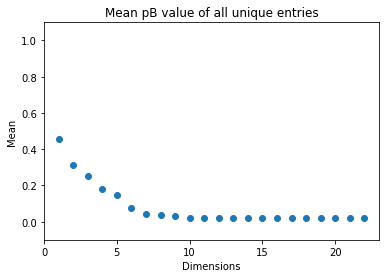

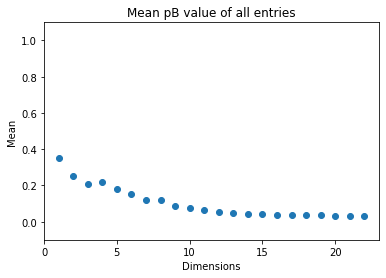

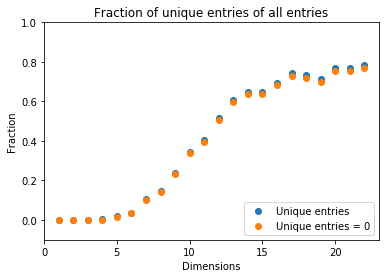

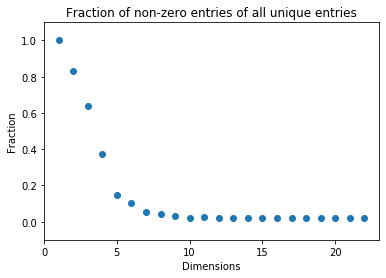

In [27]:
over_columns = np.transpose(over_list)
plt.scatter(list(range(1,23)),over_columns[1])
plt.ylim(-0.1,1.1)
plt.xlim(0,23)
plt.xlabel("Dimensions")
plt.ylabel("Mean")
plt.title("Mean pB value of all unique entries")
plt.show()
plt.close()
            
over_columns = np.transpose(over_list)
plt.scatter(list(range(1,23)),over_columns[2])
plt.ylim(-0.1,1.1)
plt.xlim(0,23)
plt.xlabel("Dimensions")
plt.ylabel("Mean")
plt.title("Mean pB value of all entries")
plt.show()
plt.close()
            
plt.figure()
plt.scatter(list(range(1,23)),over_columns[0], label = "Unique entries")
plt.scatter(list(range(1,23)),over_columns[3], label = "Unique entries = 0")
plt.xlabel("Dimensions")
plt.ylabel("Fraction")
plt.ylim(-0.1,1)
plt.xlim(0,23)
plt.legend(loc = "lower right")
plt.title("Fraction of unique entries of all entries")
plt.show()
plt.figure()

plt.scatter(list(range(1,23)),(over_columns[0]-over_columns[3])/over_columns[0])
plt.ylim(-0.1,1.1)
plt.xlim(0,23)
plt.xlabel("Dimensions")
plt.ylabel("Fraction")
plt.title("Fraction of non-zero entries of all unique entries")
plt.show()
plt.close()

In [101]:
def balance(balance_bins: int):
    for i in range(1,balance_bins + 1):
        #print(len([ele for ele in pBs if (ele >= (i-1)*0.1 and ele < i*0.1)]))
        print(i/balance_bins, len([ele for ele in train_pBs \
            if (ele >= (i-1)/balance_bins and ele < i/balance_bins)]))
#balance(20)

bins = 20
lens = [len([ele for ele in train_pBs if (ele >= (b-1)/(bins-1) and ele < b/(bins-1))]) for b in range(1, bins +1)]

train_pBs_len = len(train_pBs)

balancers = [train_pBs_len / elem for elem \
    in [len([ele for ele in train_pBs \
    if (ele >= (b-1)/(bins-1) and ele < b/(bins-1))]) for b in range(1, bins +1)] if elem > 0]
sum_ba = sum(balancers)
balancers = [ele / sum_ba for ele in balancers]

In [ ]:
#print([*zip([(key, label) for key, label in pB_dict.items()])])
#print([key for key, label in pB_dict.items()])
#print([label for key, label in pB_dict.items()])
trimmed_keys = list(map(list,[list(map(lambda x: float(x)/(c.resolution-1), key)) for key, label in pB_dict.items() if label > 0.0 and label < 1.0]))
trimmed_labels = [label for key, label in pB_dict.items() if label > 0.0 and label < 1.0]
trimmed_back_keys = list(map(list,[list(map(lambda x: float(x)/(c.resolution-1), key)) for key, label in pB_dict.items() if label < 1.0]))
trimmed_back_labels = [label for key, label in pB_dict.items() if label < 1.0]
print(len(trimmed_keys))
print(len(trimmed_back_keys))

#print(trimmed_keys[:10])
#print(trimmed_labels[:10])

In [84]:
gridO.plot_distribution(train_grid_snapshots,6,20,var_names,"untrimmed")
gridO.plot_distribution(trimmed_keys,6,20,var_names,"trimmed_both")
gridO.plot_distribution(trimmed_back_keys,6,20,var_names,"trimmed_back")

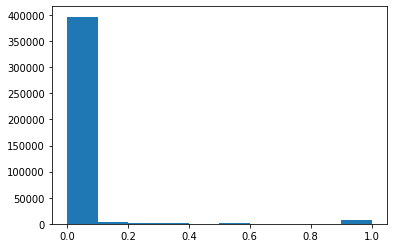

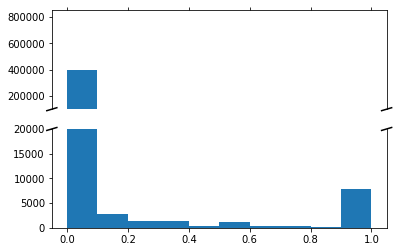

NameError: name 'trimmed_labels' is not defined

<Figure size 432x288 with 0 Axes>

In [33]:
#print(len(pB_dict))
#print(max([label for key, label in pB_dict.items()]))
#print(min([label for key, label in pB_dict.items()]))
#print(len([label for key, label in pB_dict.items() if label > 0.0]))
#print(len([label for key, label in pB_dict.items() if label == 0.0]))
#print(len([label for key, label in pB_dict.items() if label < 0.25]))
#print(len([label for key, label in pB_dict.items() if label > 0.25]))

def broken_hist(xs, bins, y_lower_1, y_upper_1, y_lower_2, y_upper_2, filename):
    f, (ax, ax2) = plt.subplots(2, 1, sharex=True)
    # ax.hist([label for key, label in pB_dict.items()], 100)
    # ax2.hist([label for key, label in pB_dict.items()], 100)
    ax.hist(xs, bins)
    ax2.hist(xs, bins)
    ax.set_ylim(y_lower_2, y_upper_2)  # outliers only
    ax2.set_ylim(y_lower_1, y_upper_1)  # most of the data
    # hide the spines between ax and ax2
    ax.spines['bottom'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax.xaxis.tick_top()
    ax.tick_params(labeltop=False)  # don't put tick labels at the top
    ax2.xaxis.tick_bottom()

    d = .015  # how big to make the diagonal lines in axes coordinates
    # arguments to pass to plot, just so we don't keep repeating them
    kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
    ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
    ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

    kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
    ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
    ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal
    plt.savefig(filename)
    plt.show()
    

plt.figure()
plt.hist(train_pBs, 10)
plt.savefig("pB_untrimmed.png")
plt.show()

broken_hist(train_pBs, 10, 0, 20000, 100000, 850000, "pBs.png")

plt.figure()
plt.hist(trimmed_labels, 10)
plt.savefig("trimmed_labels.png")
plt.show()
    
broken_hist(trimmed_back_labels, 10, 0, 8000, 10000, 400000, "Hist_scaled_labels.png")


In [35]:
# generates the dataset by feeding in a tuple, of dictionaries 
# (alternative would be a tuble of lists)
"""
train_ds = tf.data.Dataset.from_tensor_slices(
    ({c.input_name: dataO.train_norm_past_snapshots}, 
    {c.output_name_1: dataO.train_snapshot_labels, 
    c.output_name_2: dataO.train_norm_snapshots}, 
    {c.output_name_1: dataO.train_snapshot_weights, 
    c.output_name_2: dataO.train_snapshot_weights})) \
        .shuffle(snapO.snapshot_cnt) \
        .batch(c.batch_size)
print("train_ds generated")
val_ds = tf.data.Dataset.from_tensor_slices(
    ({c.input_name: dataO.val_norm_past_snapshots}, 
    {c.output_name_1: dataO.val_snapshot_labels, 
    c.output_name_2: dataO.val_norm_snapshots}, 
    {c.output_name_1: dataO.val_snapshot_weights, 
    c.output_name_2: dataO.val_snapshot_weights})) \
        .shuffle(snapO.snapshot_cnt) \
        .batch(c.batch_size)
print("val_ds generated")
"""
pass